# MovieLens Recommendation System

### Problem Statement
MovieLens provide anonymous rating data, which include user id + movie id + rating, also include metadata of movies and users.
This notebook is trying to use incremental SVD for handling new user cold start problem.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

import movieLens_util

## 1. user - movie rating dataframe

In [17]:
df_data, df_movie_meta, df_catalog, df_user_meta = movieLens_util.load_movieLens_dataset('ml-100k')

In [18]:
## user-item metadata
header = ['count', 'column']
df_meta = pd.read_csv('ml-100k/u.info', sep=' ', names=header)

df_meta

,count,column
0,943,users
1,1682,items
2,100000,ratings


### EDA for Movie rating df

### Obervasion
1. Most rating around 4 - average rating 3.5 (100000 rating)
2. Rating Date for this dataset only focus on 1997,1998 (time is not a good feature in this dataset)
3. Most Viewed Movie & Most Rate Movie is totally different, since when less people watch this movie then rate of this movie will be higher than popular movie.

In [19]:
print("Mean of rating: " + str(df_data['rating'].mean()))
print("Total Rating Count: " + str(df_data['rating'].shape[0]))

Mean of rating: 3.52986
Total Rating Count: 100000


In [20]:
## rating number distribution
df_data.groupby('rating').size().reset_index(name='counts')

,rating,counts
0,1,6110
1,2,11370
2,3,27145
3,4,34174
4,5,21201


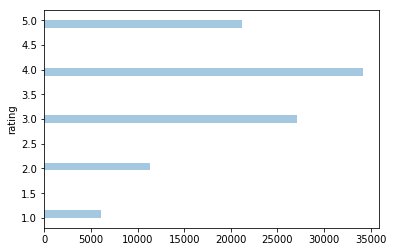

In [21]:
## rating count distribution
sns.distplot(df_data['rating'], hist=True, kde=False, bins=25, vertical=True)

In [22]:
## rating year distribution
## since only have Movielens 100k is small dataset from 2M, so only include 1997,1998

df_data.groupby(df_data['rate_datetime'].dt.year).size().reset_index(name='counts')

,rate_datetime,counts
0,1997,52899
1,1998,47101


In [23]:
## find the top-view movie & top-rated movie
movie_viewed_cnt = df_data.groupby('item_id').size().reset_index(name='counts')
movie_viewed_cnt.sort_values('counts', ascending=False).head(5)

,item_id,counts
49,50,583
257,258,509
99,100,508
180,181,507
293,294,485


In [24]:
## aggregate mean & count function together
movie_viewed_cnt_rate = df_data.groupby('item_id') \
                               .agg({'user_id': 'size', 'rating': 'mean'}) \
                               .rename(columns={'user_id': 'viewed', 'rating': 'mean_rate'}) \
                               .reset_index()
## new version
# movie_viewed_cnt_rate = df_data.groupby('item_id') \
#                                .agg(count=('user_id', 'size'), mean_rate=('rating', 'mean')) 
#                                .reset_index()


## merge user-movie with movie meta dataframe

In [25]:
## merge two dataframe with common columns
df_movie_stat = pd.merge(df_movie_meta, movie_viewed_cnt_rate, 
                         left_on='movie_id', right_on='item_id', how='left') \
                         .drop('item_id', axis=1) 


In [26]:
df_movie_stat.sort_values('viewed', ascending=False).head(10)

,movie_id,name,release_date,link,unknown,Action,Adventure,Animation,Children's,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,viewed,mean_rate
49,50,Star Wars (1977),01-Jan-1977,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,1,1,0,1,0,583,4.358491
257,258,Contact (1997),11-Jul-1997,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,509,3.803536
99,100,Fargo (1996),14-Feb-1997,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,508,4.155512
180,181,Return of the Jedi (1983),14-Mar-1997,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,1,1,0,1,0,507,4.007890
293,294,Liar Liar (1997),21-Mar-1997,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,485,3.156701
285,286,"English Patient, The (1996)",15-Nov-1996,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,481,3.656965
287,288,Scream (1996),20-Dec-1996,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,478,3.441423
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,452,3.878319
299,300,Air Force One (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,431,3.631090
120,121,Independence Day (ID4) (1996),03-Jul-1996,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,429,3.438228


In [27]:
df_movie_stat[df_movie_stat['viewed']>=100].sort_values('mean_rate', ascending=False).head(10)

,movie_id,name,release_date,link,unknown,Action,Adventure,Animation,Children's,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,viewed,mean_rate
407,408,"Close Shave, A (1995)",28-Apr-1996,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,112,4.491071
317,318,Schindler's List (1993),01-Jan-1993,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,298,4.466443
168,169,"Wrong Trousers, The (1993)",01-Jan-1993,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,118,4.466102
482,483,Casablanca (1942),01-Jan-1942,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,243,4.456790
63,64,"Shawshank Redemption, The (1994)",01-Jan-1994,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,283,4.445230
602,603,Rear Window (1954),01-Jan-1954,http://us.imdb.com/M/title-exact?Rear%20Window...,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,209,4.387560
11,12,"Usual Suspects, The (1995)",14-Aug-1995,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,267,4.385768
49,50,Star Wars (1977),01-Jan-1977,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,1,1,0,1,0,583,4.358491
177,178,12 Angry Men (1957),01-Jan-1957,http://us.imdb.com/M/title-exact?12%20Angry%20...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,125,4.344000
133,134,Citizen Kane (1941),01-Jan-1941,http://us.imdb.com/M/title-exact?Citizen%20Kan...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,198,4.292929


## train the model based on surprise package

In [28]:
## load built-in dataset
# data = Dataset.load_builtin('ml-100k')

In [23]:
df_data.head()

,user_id,item_id,rating,timestamp,rate_datetime
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16


In [66]:
## load dataframe into surprise dataset object
## this time also need Reader object since need to scale the rating range

reader = Reader(rating_scale=(1,5))
algo = SVD()
data_input = Dataset.load_from_df(df_data_old_user[['user_id','item_id','rating']], reader)

## train & test the model with SVD
# trainset, testset = train_test_split(data_input, test_size=.25)
trainset = data_input.build_full_trainset()
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

RMSE: 0.6726


0.6725572140430708

In [30]:
## cross -validation usually used for testing model average estimated performance 
cross_validate(algo, data_input, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9299  0.9446  0.9447  0.9286  0.9380  0.9371  0.0069  
MAE (testset)     0.7319  0.7480  0.7439  0.7307  0.7364  0.7382  0.0068  
Fit time          4.39    4.48    4.69    4.45    4.48    4.50    0.10    
Test time         0.13    0.17    0.11    0.18    0.11    0.14    0.03    


{'test_rmse': array([0.92986646, 0.94455426, 0.94470313, 0.9286114 , 0.93798809]),
 'test_mae': array([0.73185002, 0.74801448, 0.74392995, 0.73066444, 0.73636045]),
 'fit_time': (4.389150142669678,
  4.477230787277222,
  4.6899049282073975,
  4.452677965164185,
  4.475344657897949),
 'test_time': (0.12881159782409668,
  0.16838669776916504,
  0.11328840255737305,
  0.17679524421691895,
  0.10756897926330566)}

### Current tasks:
Finish: 
1. Learn how to use Surprise for training model
2. Learn how to serialize the model and reload
3. Learn how to cross-validate the model

Challenge:
1. How to solve the cold-start issue - Represented based MF each new user need to rate some item before predict
2. Think about using deep learning issue for training